# Exploratory Data Analysis

## Import Libraries

In [2]:
import pymongo
import pandas as pd
import numpy as np
import json
import os
import yaml

import matplotlib.pyplot as plt
import seaborn as sns


import re

## Load Data from DB

In [3]:
with open("config.yaml", "r") as ymlfile:
    settings = yaml.safe_load(ymlfile)


isRemote = False


try:
    if (isRemote):
        client = pymongo.MongoClient(host = settings['mongo-remote']['host'],
                                     port = settings['mongo-remote']['port'],
                                     username = settings['mongo-remote']['user'],
                                     password = settings['mongo-remote']['pw'],
                                     authMechanism= settings['mongo-remote']['authMechanism'])
        client.server_info()  # force connection on a request as the
        # connect=True parameter of MongoClient seems
        # to be useless here
    else:
        client = pymongo.MongoClient("mongodb://localhost:27017/")
        client.server_info()  # force connection on a request as the
    # connect=True parameter of MongoClient seems
    # to be useless here
except pymongo.errors.ServerSelectionTimeoutError as err:
    # do whatever you need
    print(err)


In [4]:
db = client["parliament"]
articles = db["articles"]

In [5]:
mongo_df = pd.DataFrame.from_records(articles.find())
mongo_df.head()

,_id,article_text,chunks,cleaned_join,dominant_topic,html_clean,parliament_num,parsed_convo,persons_involved,session_num,session_type,sitting_date,sitting_num,src_url,title,volume_num
0,5d27eca6172d9aa762d4802f,<p>[(proc text) Debate resumed. (proc text)]</...,[{'content': '[(proc text) Debate resumed. (pr...,[(proc text) Debate resumed. (proc text)]<br/>...,Society,"[[(proc text) Debate resumed. (proc text)], Mr...",13,[{'content': '[(proc text) Debate resumed. (pr...,"[Prof Lim Sun Sun, Miss Cheng Li Hui, An hon M...",2,SECOND READING BILLS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,PROTECTION FROM ONLINE FALSEHOODS AND MANIPULA...,94
1,5d27eca6172d9aa762d48030,"<p class=""ql-align-justify"">4 <strong>Mr Vikra...",[{'content': 'Mr Vikram Nair asked the Ministe...,Mr Vikram Nair asked the Minister for Foreign ...,Society,[Mr Vikram Nair asked the Minister for Foreign...,13,[{'content': 'Mr Vikram Nair asked the Ministe...,"[Mr Speaker, Assoc Prof Walter Theseira, Mr Vi...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,STATE OF BILATERAL RELATIONS WITH MALAYSIA FOL...,94
2,5d27eca6172d9aa762d48031,"<p class=""ql-align-justify"">8 <strong>Assoc Pr...",[{'content': 'Assoc Prof Walter Theseira asked...,Assoc Prof Walter Theseira asked the Minister ...,Internal Security,[Assoc Prof Walter Theseira asked the Minister...,13,[{'content': 'Assoc Prof Walter Theseira asked...,"[Ms Anthea Ong, Assoc Prof Walter Theseira, Ms...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,COMPANIES WITH MEASURES TO DEAL WITH WORKPLACE...,94
3,5d27eca6172d9aa762d48032,<p>5 <strong>Ms Irene Quay Siew Ching</strong>...,[{'content': 'Ms Irene Quay Siew Ching asked t...,Ms Irene Quay Siew Ching asked the Minister fo...,Environment,[Ms Irene Quay Siew Ching asked the Minister f...,13,[{'content': 'Ms Irene Quay Siew Ching asked t...,"[Ms Irene Quay Siew Ching, Dr Lam Pin Min, The...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,REVIEW OF DRUG TESTING STANDARDS IN SINGAPORE ...,94
4,5d27eca6172d9aa762d48033,"<p class=""ql-align-justify"">2 <strong>Mr Lim B...",[{'content': 'Mr Lim Biow Chuan asked the Depu...,Mr Lim Biow Chuan asked the Deputy Prime Minis...,Employment,[Mr Lim Biow Chuan asked the Deputy Prime Mini...,13,[{'content': 'Mr Lim Biow Chuan asked the Depu...,"[The Second Minister for Finance, Mr Lim Biow ...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,LIVING IN PRIVATE PROPERTIES BUT WITH NO DECLA...,94


# Create Speaker-Speaker Interaction Table

Given each document, we want to be able to see the interaction between one speaker to the next, including the response to procedural questions. This would give us an understanding of how speakers interact with each other.

In [234]:
network_template = pd.DataFrame(columns=['from','to','docID','doctopic'])

In [221]:
seq = []

for val in mongo_df.iloc[2].chunks.values():
    if val['entity'] == 'NA' or len(val['entity']) >100:
        seq.append('PROC')
    else:
        seq.append(val['entity'])

In [222]:
seq

['Assoc Prof Walter Theseira',
 'PROC',
 'Assoc Prof Walter Theseira (Nominated Member)',
 'Ms Low Yen Ling',
 'Mr Patrick Tay Teck Guan (West Coast)',
 'Ms Low Yen Ling',
 'Ms Anthea Ong (Nominated Member)',
 'Ms Low Yen Ling']

In [223]:
for idx in range(1, len(seq)):
    network_template = network_template.append({
        'from' :  seq[idx-1],
        'to' : seq[idx],
    }, ignore_index = True)

In [224]:
network_template.iloc[:3]

,from,to,docID,doctopic
0,Assoc Prof Walter Theseira,PROC,NaN,NaN
1,PROC,Assoc Prof Walter Theseira (Nominated Member),NaN,NaN
2,Assoc Prof Walter Theseira (Nominated Member),Ms Low Yen Ling,NaN,NaN


In [236]:
def construct_network(doc, template):
    seq = []
    
    docID = doc._1 ## change to '_id' for nontuple operation
    chunks = doc.chunks
    topic = doc.dominant_topic
    
    for val in chunks.values():
        if val['entity'] == 'NA' or len(val['entity']) >100:
            seq.append('PROC')
        else:
            seq.append(val['entity'])
            
    for idx in range(1, len(seq)):
        template = template.append({
            'from' :  seq[idx-1],
            'to' : seq[idx],
            'docID' : docID,
            'doctopic' : topic
        }, ignore_index = True)
        
    return template

In [233]:
construct_network(mongo_df.iloc[2], network_template)

,from,to,docID,doctopic
0,Assoc Prof Walter Theseira,PROC,5d27eca6172d9aa762d48031,Internal Security
1,PROC,Assoc Prof Walter Theseira (Nominated Member),5d27eca6172d9aa762d48031,Internal Security
2,Assoc Prof Walter Theseira (Nominated Member),Ms Low Yen Ling,5d27eca6172d9aa762d48031,Internal Security
3,Ms Low Yen Ling,Mr Patrick Tay Teck Guan (West Coast),5d27eca6172d9aa762d48031,Internal Security
4,Mr Patrick Tay Teck Guan (West Coast),Ms Low Yen Ling,5d27eca6172d9aa762d48031,Internal Security
5,Ms Low Yen Ling,Ms Anthea Ong (Nominated Member),5d27eca6172d9aa762d48031,Internal Security
6,Ms Anthea Ong (Nominated Member),Ms Low Yen Ling,5d27eca6172d9aa762d48031,Internal Security


In [237]:
from tqdm import tqdm

for row in tqdm(mongo_df.itertuples()):
    network_template = construct_network(row,network_template)

9531it [03:05, 51.35it/s]


In [39]:
network_template.to_csv('networks.csv')

In [16]:
network_template = pd.read_csv('networks.csv')
network_template.drop(columns='Unnamed: 0',inplace=True)

# Get Speaker statistics

In [32]:
network_template['from'].value_counts().head()

PROC             10967
The Chairman      1727
Mdm Speaker        967
Mr Speaker         954
Ms Sylvia Lim      279
Name: from, dtype: int64

In [39]:
def clean_names(name):
    try:
        if re.match('[t|T]he',name[:5]):
            if 'The Chairman' not in name:
                return (re.search(r'\((.*?)\)',name).group(1))
            else:
                return name
        else:
            return(re.sub(r'(\(.*?\))','',name).strip().replace('.',' '))
    except AttributeError:
        print(name)
    except TypeError:
        pass

In [40]:
clean_names("Er Lee Bee Wah (Ang Mo Kio) (In Malay)")

'Er Lee Bee Wah'

In [41]:
network_template['from_clean'] = network_template['from'].map(clean_names)
network_template['to_clean'] = network_template['to'].map(clean_names)

In [42]:
network_template.head()

,from,to,docID,doctopic,from_clean,to_clean
0,PROC,Mr Deputy Speaker,5d27eca6172d9aa762d4802f,Society,PROC,Mr Deputy Speaker
1,Mr Deputy Speaker,Mr Png Eng Huat (Hougang),5d27eca6172d9aa762d4802f,Society,Mr Deputy Speaker,Mr Png Eng Huat
2,Mr Png Eng Huat (Hougang),Mr Deputy Speaker,5d27eca6172d9aa762d4802f,Society,Mr Png Eng Huat,Mr Deputy Speaker
3,Mr Deputy Speaker,The Minister for Communications and Informatio...,5d27eca6172d9aa762d4802f,Society,Mr Deputy Speaker,Mr S Iswaran
4,The Minister for Communications and Informatio...,Mr Deputy Speaker,5d27eca6172d9aa762d4802f,Society,Mr S Iswaran,Mr Deputy Speaker


## Visualise the Dataset

Next, we want to clean the data even further to drop the prefixes for each speaker

In [191]:
network_template.from_clean.value_counts().head()

PROC             10957
The Chairman      2064
Mdm Speaker       1174
Mr Speaker        1118
Ms Sylvia Lim      526
Name: from_clean, dtype: int64

In [47]:
network_template.dropna(inplace=True)

In [48]:
network_template['from_clean'] = network_template.from_clean.map(lambda x : (re.sub(r'(\(.*?\))','',x).strip()))
network_template['to_clean'] = network_template.to_clean.map(lambda x : (re.sub(r'(\(.*?\))','',x).strip()))

In [49]:
network_template['from_clean'] = network_template.from_clean.map(lambda x : x.replace('.',' '))
network_template['to_clean'] = network_template.to_clean.map(lambda x : x.replace('.',' '))

We then remove any interaction that equals to one.

In [50]:
counts = network_template['from_clean'].value_counts()
res = network_template[~network_template['from_clean'].isin(counts[counts < 2].index)]

In [51]:
counts = res['to_clean'].value_counts()
res = res[~res['to_clean'].isin(counts[counts < 2].index)]

In [52]:
re.sub(r'(\[.*?\])','','[Mr Speaker in the Chair]The Chairman')

'The Chairman'

In [53]:
res.from_clean = res.from_clean.map(lambda x: re.sub(r'(\[.*?\])','',x).strip())
res.to_clean = res.to_clean.map(lambda x: re.sub(r'(\[.*?\])','',x).strip())

In [54]:
res.from_clean = res.from_clean.map(lambda x : 'Chairman' if x == 'The Chairman' else x)
res.to_clean = res.to_clean.map(lambda x : 'Chairman' if x == 'The Chairman' else x)

In [55]:
res.from_clean = res.from_clean.map(lambda x: re.sub(r'\(|\)','',x).strip())
res.to_clean = res.to_clean.map(lambda x: re.sub(r'\(|\)','',x).strip())

Remove any residual whitespaces.

In [56]:
res['to_salutation'] = res.to_clean.map(lambda x: ''.join(x.split(maxsplit=1)[:1]))
res['from_salutation'] = res.from_clean.map(lambda x: ''.join(x.split(maxsplit=1)[:1]))

In [57]:
sum_salutations = res['to_salutation'].value_counts() + res['from_salutation'].value_counts()

In [59]:
salutations = ['Assoc','Assoc Prof','Dr','Er','Er Dr','MG','Mdm','Miss','Mrs','Ms','Prof','RAdm']
salutations_list = "|".join(salutations)

In [60]:
res['clean_from_salutation'] = res.from_clean.map(lambda x : re.sub(salutations_list,'',x).strip())
res['clean_from_salutation'] = res.clean_from_salutation.map(lambda x : re.sub('Mr','',x).strip())

res['clean_to_salutation'] = res.to_clean.map(lambda x : re.sub(salutations_list,'',x).strip())
res['clean_to_salutation'] = res.clean_to_salutation.map(lambda x : re.sub('Mr','',x).strip())

Generating the Network Diagram using networkx.

In [75]:
graph_df = res[['clean_from_salutation','clean_to_salutation']]
graph_df.rename(columns={'clean_from_salutation':'from','clean_to_salutation':'to'},inplace=True)

Grouping is performed to get the count of people per correspondence

In [76]:
grouped_graph_df = graph_df.groupby(by=['to','from']).size().reset_index().rename(columns={0:'Count'})

We generate an index containing combination of unique individuals in the `to` and `from` column.

In [77]:
unique_ppl = pd.Index(grouped_graph_df['from']
                      .append(grouped_graph_df['to'])
                      .reset_index(drop=True).unique())

In [78]:
unique_ppl



Index(['K Shanmugam', 'Lam Pin Min', 'PROC', 'Ang Mong Seng', 'Baey Yam Keng',
       'Cedric Foo Chee Keng', 'Chairman', 'Charles Chong',
       'Eunice Elizabeth Olsen', 'Gan Kim Yong',
       ...
       'Loo Choon Yong', 'Mohd Ismail Hussein', 'An hon Member',
       'Lee Boon Yang', 'Balaji Sadasivan', 'Cham Hui Fong', 'Goh Chok Tong',
       '﻿ Speaker', 'Jessie Phua', 'Lee Kuan Yew'],
      dtype='object', length=202)

In [68]:
grouped_graph_df.rename(columns={0:'count'}, inplace=True)
temp_links_list = list(grouped_graph_df.apply(lambda row: {"source": row['from'], "target": row['to'], "value": row['Count']}, axis=1))

In [69]:
links_list = []
for link in temp_links_list:
    record = {"value":link['value'], "source":unique_ppl.get_loc(link['source']),
     "target": unique_ppl.get_loc(link['target'])}
    links_list.append(record)

In [70]:
grouped_graph_cnts = grouped_graph_df.groupby('to').size().reset_index().rename(columns={'to':'name',0:'count'}).to_dict('records')

In [71]:
nodes_list = []

for idx,name in enumerate(unique_ppl):
    influence = 0
    for item in grouped_graph_cnts:
        if item['name'] == name:
            influence = item['count']
    nodes_list.append({"name":name, "id": idx, "influence" : influence })
    

In [72]:
json_prep = {"nodes":nodes_list, "links":links_list}

json_prep.keys()

dict_keys(['nodes', 'links'])

In [73]:
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

In [79]:
filename_out = 'node_export_influence.json'
json_out = open(filename_out,'w')
json_out.write(json_dump)
json_out.close()

## Add in Party Affliation / Role to network diagram

In [80]:
mp_list = pd.read_csv('clean_mp.csv',infer_datetime_format=True)

In [87]:
party_list = pd.read_csv('refer.csv',infer_datetime_format=True)

In [89]:
party_list.drop(columns=['Unnamed: 0'],inplace=True)

In [114]:
ncmp_list = pd.read_csv('ncmp.csv')
nmp_list = pd.read_csv('nmp.csv')

In [115]:
nmp_list['designation'] = 'NMP'

In [116]:
ncmp_list.head()

,ncmp,parliament
0,Daniel Goh Pei Siong,13
1,Leon Perera,13
2,Dennis Tan Lip Fong,13
3,Gerald Giam,12
4,Yee Jenn Jong,12


In [117]:
mp_list.head()

,Unnamed: 0,name,designation,birth_year,party,constituency,salutation,matched_name
0,0,AMRIN AMIN,"Senior Parliamentary Secretary, Ministry of Ho...",1/1/78,People's Action Party,Sembawang GRC,Mr,AMRIN BIN AMIN
1,1,ANG HIN KEE,Member of Parliament,1/1/65,People's Action Party,Ang Mo Kio GRC,Mr,ANG HIN KEE
2,2,ANG WEI NENG,Member of Parliament,1/1/67,People's Action Party,Jurong GRC,Mr,ANG WEI NENG
3,3,BAEY YAM KENG,"Senior Parliamentary Secretary, Ministry of Tr...",1/1/70,People's Action Party,Tampines GRC,Mr,BAEY YAM KENG
4,4,CHERYL CHAN WEI LING,Member of Parliament,1/1/76,People's Action Party,Fengshan,Miss,CHAN WEI LING CHERYL


In [118]:
nmp_list = nmp_list.rename(columns={'nmp':'name','Parliament':'parliament'})

In [119]:
ncmp_list['designation'] = 'ncmp'
ncmp_list.rename(columns={'ncmp':'name'},inplace=True)

In [120]:
combinedlist = nmp_list.append(ncmp_list,ignore_index=True)

In [124]:
combinedlist = combinedlist.append(mp_list.drop(columns="Unnamed: 0"),ignore_index=True)[['constituency','designation','name','party']]

In [133]:
combinedlist.designation = combinedlist.designation.map(lambda x : 'Nominated Member of Parliament' if x == 'NMP' else ('Non-Constituency Member of Parliament' if x=='ncmp' else x) )

In [138]:
combinedlist.fillna('NA',inplace=True)

In [146]:
# consolidate various designations
combinedlist['clean_designation'] = combinedlist.designation.map(lambda x : 'Minister' if 'Minister' in x else x)
combinedlist['clean_designation'] = combinedlist.clean_designation.map(lambda x : 'Parliamentary Secretary' if 'Parliamentary Secretary' in x else x)
combinedlist['clean_designation'] = combinedlist.clean_designation.map(lambda x : 'Mayor' if 'Mayor' in x else x)

In [157]:
combinedlist['party'] = combinedlist.party.map(lambda x : "Nominated Member of Parliament" if x == "NA" else x)

In [163]:
party_list = party_list.rename(columns={"Name":"name","Party":"party"})

In [165]:
combinedlist = combinedlist.append(party_list,ignore_index=True)

In [166]:
combinedlist.party.value_counts()

People's Action Party                     400
Workers' Party                            136
Nominated Member of Parliament            131
Independent                               106
Liberal Socialist Party                    61
Barisan Sosialis                           52
National Solidarity Party                  40
Singapore Democratic Party                 40
Singapore Alliance                         39
United People's Party                      38
Progressive Party                          30
United National Front                      30
Labour Front                               26
Singapore People's Alliance                25
Singapore Democratic Alliance              23
United People's Front                      18
Reform Party                               17
Democratic Party                           15
Singapore People's Party                   13
Labour Party                               13
United Front                               12
Singaporeans First                

In [209]:
combinedlist.to_csv('consolidated.csv')

Fuzzy extraction of names using the fuzzy wuzzy library to closely approximate a name to the party

In [178]:
from fuzzywuzzy import process, fuzz

In [241]:
for item in nodes_list:
    try:
        if item['name'] != 'None':
            idx = process.extractOne(item['name'],combinedlist.name, score_cutoff=80) [2]
            item['party'] = combinedlist.iloc[idx].party
        else:
            item['party'] = "NA"
    except TypeError:
        print(item)
        item['party'] = "NA"
        continue
    

{'name': 'PROC', 'id': 2, 'influence': 159, 'party': 3}
{'name': 'Chairman', 'id': 6, 'influence': 170, 'party': 3}


{'name': '', 'id': 21, 'influence': 3, 'party': 3}
{'name': 'Speaker', 'id': 69, 'influence': 163, 'party': 3}
{'name': 'Deputy Speaker', 'id': 110, 'influence': 112, 'party': 3}
{'name': 'Higher Education and Skills', 'id': 173, 'influence': 4, 'party': 3}
{'name': 'Industry', 'id': 175, 'influence': 4, 'party': 3}
{'name': 'Schools', 'id': 181, 'influence': 4, 'party': 3}
{'name': 'Trade', 'id': 182, 'influence': 4, 'party': 3}
{'name': 'Minister of State for Health', 'id': 186, 'influence': 1, 'party': 3}
{'name': '\ufeff Speaker', 'id': 199, 'influence': 2, 'party': 3}


In [242]:
parties = []
for item in nodes_list:
    parties.append(item['party'])

dict
legend = {}
for idx,k in enumerate(list(set(parties))):
    legend[k] = idx

In [243]:
nodes_list[:3]

[{'name': 'K Shanmugam',
  'id': 0,
  'influence': 62,
  'party': "People's Action Party"},
 {'name': 'Lam Pin Min',
  'id': 1,
  'influence': 92,
  'party': "People's Action Party"},
 {'name': 'PROC', 'id': 2, 'influence': 159, 'party': 'NA'}]

In [244]:
for ent in nodes_list:
    ent['party_key'] = legend[ent['party']]

In [245]:
legend

{"Workers' Party": 0,
 "Singapore People's Party": 1,
 'Presidential Office': 2,
 'NA': 3,
 'Barisan Sosialis': 4,
 "People's Action Party": 5,
 'Nominated Member of Parliament': 6}

In [247]:
json_prep = {"nodes":nodes_list, "links":links_list}

json_prep.keys()

dict_keys(['nodes', 'links'])

In [248]:
json_dump = json.dumps(json_prep, indent=1, sort_keys=True)

In [249]:
filename_out = 'node_export_party_influence.json'
json_out = open(filename_out,'w')
json_out.write(json_dump)
json_out.close()

## Perform EDA on topics over time

In [6]:
topic_date = mongo_df[['dominant_topic','sitting_date']].copy()

In [7]:
topic_date.set_index(topic_date["sitting_date"],inplace=True)

In [8]:
topic_groupings_count = topic_date.groupby(by='dominant_topic').resample('M', how='count').rename(columns={'dominant_topic':'topic_count'})['topic_count'].reset_index()
topic_groupings_count.head()

/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:1436: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  return get_resampler_for_grouping(self, rule, *args, **kwargs)


,dominant_topic,sitting_date,topic_count
0,Business,2009-01-31,2
1,Business,2009-02-28,4
2,Business,2009-03-31,1
3,Business,2009-04-30,0
4,Business,2009-05-31,10


In [9]:
topic_groupings_count['year'] = topic_groupings_count.sitting_date.map(lambda x : x.year)
topic_groupings_count['month'] = topic_groupings_count.sitting_date.map(lambda x : x.month)

In [10]:
topic_groupings_count.dominant_topic.value_counts()

Business             125
Internal Security    125
External Security    125
Healthcare           125
Law                  125
Society              125
Environment          125
Living               125
Education            125
Employment           125
Name: dominant_topic, dtype: int64

In [11]:
topic_groupings_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 5 columns):
dominant_topic    1250 non-null object
sitting_date      1250 non-null datetime64[ns]
topic_count       1250 non-null int64
year              1250 non-null int64
month             1250 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 48.9+ KB


Text(0.5, 1, 'Education')

<Figure size 1440x720 with 0 Axes>

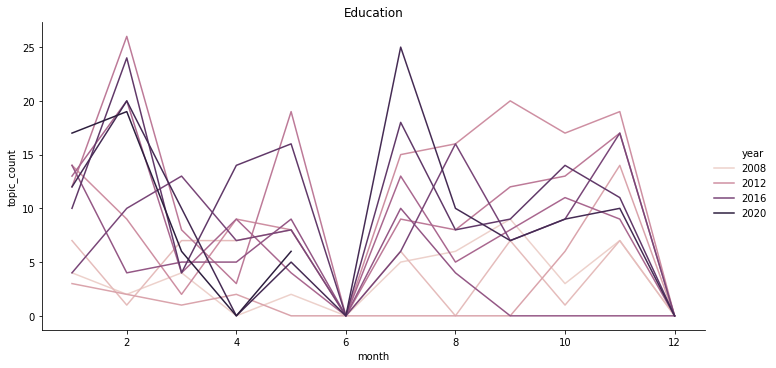

In [18]:
topic = "Education"

plt.figure(figsize=(20,10))
ax = sns.relplot(x="month", y="topic_count", hue="year", kind = "line", data=topic_groupings_count[topic_groupings_count['dominant_topic'] == topic],aspect=2)
plt.title(topic)

[None, None, None, None, None, None, None, None, None, None]

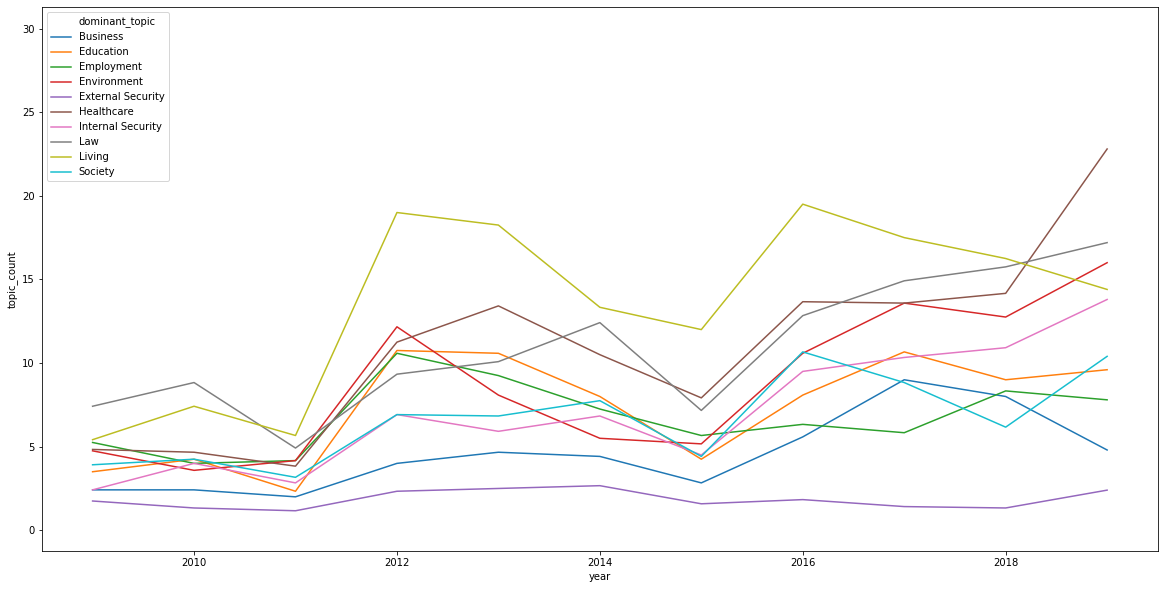

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="year", y="topic_count", hue="dominant_topic",  data=topic_groupings_count)
plt.setp(ax.collections, alpha=0)